# XGBoost Test

In [1]:
import pandas as pd
import pickle

import modules.preprocessing_functions as ppf
import modules.xgboost_functions as xgfun

## Load testing data 

In [2]:
def load_test_data():

    google_drive_path = ('~/Google Drive/My Drive/Lighthouse Labs/'
                             + 'Mid-term Project/Data-Jan/')
    file = 'flights_test.csv'
    
    path = google_drive_path + file
    
    return pd.read_csv(path, nrows=150623)  # 150623 records in first week of Jan

In [3]:
test_data = load_test_data()

In [4]:
test_data

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,1577854800000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1577854800000,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,1577854800000,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,1577854800000,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,1577854800000,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150618,1578373200000,DL,DL_CODESHARE,DL,4813,9E,N605LR,4813,11433,DTW,"Detroit, MI",12478,JFK,"New York, NY",1755,1952,N,117,1,509
150619,1578373200000,DL,DL_CODESHARE,DL,4814,9E,N919XJ,4814,11996,GSP,"Greer, SC",12953,LGA,"New York, NY",600,759,N,119,1,610
150620,1578373200000,DL,DL_CODESHARE,DL,4815,9E,N936XJ,4815,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1715,1816,N,121,1,589
150621,1578373200000,DL,DL_CODESHARE,DL,4815,9E,N936XJ,4815,15919,XNA,"Fayetteville, AR",10397,ATL,"Atlanta, GA",1851,2145,N,114,1,589


## Process testing data

In [22]:
def process(df, purge: 'bool' = True):
    """
    Applies preprocessing steps to testing data
    
    Parameters
    ----------
    df : Pandas DataFrame
    
    Returns
    -------
    df : Pandas DataFrame
    """
    
    # Convert timestamp string to datetime
    df['fl_date'] = pd.to_datetime(df['fl_date'], unit='ms')
    
    # Filter for first week of Jan
    df = df[((df['fl_date'] >= '2020-01-01') &
                     (df['fl_date'] <= '2020-01-07 05:00:00'))]
    
    # Change date to day of month
    df['fl_date'] = df['fl_date'].dt.day
    
    if purge == True:
        # Drop unused columns
        df = ppf.flight_test_features(df, purged=True)
    
    return df

In [6]:
X = process(test_data)
X

,fl_date,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,distance
0,1,WN,N951WN,ONT,"Ontario, CA",SFO,"San Francisco, CA",1810,1945,363
1,1,WN,N467WN,ONT,"Ontario, CA",SFO,"San Francisco, CA",1150,1320,363
2,1,WN,N7885A,ONT,"Ontario, CA",SJC,"San Jose, CA",2020,2130,333
3,1,WN,N551WN,ONT,"Ontario, CA",SJC,"San Jose, CA",1340,1455,333
4,1,WN,N968WN,ONT,"Ontario, CA",SJC,"San Jose, CA",915,1035,333
...,...,...,...,...,...,...,...,...,...,...
150618,7,9E,N605LR,DTW,"Detroit, MI",JFK,"New York, NY",1755,1952,509
150619,7,9E,N919XJ,GSP,"Greer, SC",LGA,"New York, NY",600,759,610
150620,7,9E,N936XJ,ATL,"Atlanta, GA",XNA,"Fayetteville, AR",1715,1816,589
150621,7,9E,N936XJ,XNA,"Fayetteville, AR",ATL,"Atlanta, GA",1851,2145,589


## Map categories to delay performance indicators

In [7]:
def map_delay_performance(df, time_period: 'str' = 'month'):
    """
    Map categorical features to delay performance indicators
    
    Parameters
    ----------
    df : Pandas DataFrame
    time_period : string 'week', 'month'
        
    Returns
    -------
    df : Pandas DataFrame
    """
    
    feature_dict = {
        'origin' : 'dep_delay',
        'origin_city_name' : 'dep_delay',
        'dest' : 'arr_delay',
        'dest_city_name' : 'arr_delay',
        'tail_num' : 'arr_delay',
        'op_unique_carrier' : 'arr_delay'
    }
    
    for k, v in feature_dict.items():
        stats = pd.read_csv(
            f'../data/feature_average_delay_stats/{k}_{v}_stats.csv',
            index_col=[0]
        )
        
        # Map 2019 values
        df[f'{k}_{time_period}_mean_{v}'] = (
            df[k].map(stats[f'2019_{time_period}_{k}_mean_{v}'])
        )
        
        # For missing values Map to 2018 values
        df[f'{k}_{time_period}_mean_{v}'].fillna(
            df[k].map(stats[f'2018_{time_period}_{k}_mean_{v}'])
        )
        
        df.drop(k, axis=1, inplace=True)
    
    df[f'tail_num_{time_period}_mean_arr_delay'].fillna(
        df[f'op_unique_carrier_{time_period}_mean_arr_delay'],
        inplace=True
    )
    
    df = ppf.process_nan_values(
        df=df,
        features_to_mean=[
            f'origin_{time_period}_mean_dep_delay',
            f'dest_{time_period}_mean_arr_delay',
            f'tail_num_{time_period}_mean_arr_delay',
            f'op_unique_carrier_{time_period}_mean_arr_delay'
        ]
    )
    
    return df

In [8]:
X = map_delay_performance(X)
X

,fl_date,crs_dep_time,crs_arr_time,distance,origin_month_mean_dep_delay,origin_city_name_month_mean_dep_delay,dest_month_mean_arr_delay,dest_city_name_month_mean_arr_delay,tail_num_month_mean_arr_delay,op_unique_carrier_month_mean_arr_delay
0,1,1810,1945,363,2.968421,2.968421,4.197527,4.197527,-0.672840,-1.495835
1,1,1150,1320,363,2.968421,2.968421,4.197527,4.197527,-0.961290,-1.495835
2,1,2020,2130,333,2.968421,2.968421,-2.292048,-2.292048,2.285714,-1.495835
3,1,1340,1455,333,2.968421,2.968421,-2.292048,-2.292048,-2.556180,-1.495835
4,1,915,1035,333,2.968421,2.968421,-2.292048,-2.292048,-2.695946,-1.495835
...,...,...,...,...,...,...,...,...,...,...
150618,7,1755,1952,509,7.314534,7.314534,0.509192,6.721807,-0.142857,-1.481239
150619,7,600,759,610,3.180389,3.180389,11.603701,6.721807,9.091667,-1.481239
150620,7,1715,1816,589,4.043138,4.043138,0.189560,0.189560,-4.867133,-1.481239
150621,7,1851,2145,589,3.609462,3.609462,-4.780172,-4.780172,-4.867133,-1.481239


In [9]:
def drop_corr(df, time_period: 'str' = 'month'):
    """
    Drop highly correlated features
    """
    
    df.drop(['crs_dep_time',
            f'origin_city_name_{time_period}_mean_dep_delay',
            f'dest_city_name_{time_period}_mean_arr_delay'],
           axis=1,
           inplace=True)
    
    return df

In [10]:
X = drop_corr(X)

## Apply scaling

In [11]:
# load scaler from file
scaler = pickle.load(open('models/xgboost_scaler.pickle.dat', 'rb'))

In [12]:
X_test = pd.DataFrame(
    scaler.transform(X=X),
    columns=X.columns
)

In [13]:
X_test

,fl_date,crs_arr_time,distance,origin_month_mean_dep_delay,dest_month_mean_arr_delay,tail_num_month_mean_arr_delay,op_unique_carrier_month_mean_arr_delay
0,0.0,0.810338,0.067044,0.531433,0.573483,0.308626,0.393582
1,0.0,0.549812,0.067044,0.531433,0.573483,0.306419,0.393582
2,0.0,0.887453,0.060985,0.531433,0.467747,0.331268,0.393582
3,0.0,0.606086,0.060985,0.531433,0.467747,0.294213,0.393582
4,0.0,0.431013,0.060985,0.531433,0.467747,0.293143,0.393582
...,...,...,...,...,...,...,...
150618,1.0,0.813256,0.096527,0.617517,0.513388,0.312682,0.394496
150619,1.0,0.315965,0.116922,0.535631,0.694154,0.383355,0.394496
150620,1.0,0.756565,0.112682,0.552720,0.508180,0.276527,0.394496
150621,1.0,0.893706,0.112682,0.544130,0.427207,0.276527,0.394496


## Load model

In [14]:
# load model from file
xg_reg = pickle.load(open('models/flight_delay_xgboost.pickle.dat', 'rb'))

## Make prediction

In [15]:
y_pred_2020 = xg_reg.predict(X_test)

In [17]:
y_pred_2020_df = pd.DataFrame(y_pred_2020)
y_pred_2020_df.describe()

,0
count,150623.000000
mean,0.075182
std,8.354204
min,-41.062374
25%,-5.474369
50%,-0.932551
75%,4.443670
max,65.096344


In [18]:
y_pred_2020_df.skew()

0    1.051386
dtype: float32

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

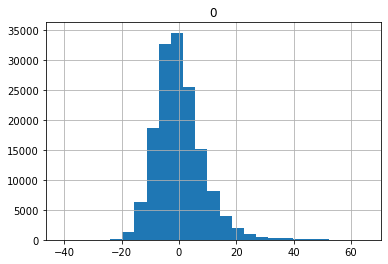

In [19]:
y_pred_2020_df.hist(bins=25)

## Make submission file

In [37]:
def sub_process(df):
    """
    Applies preprocessing steps for submission file
    
    Parameters
    ----------
    df : Pandas DataFrame
    
    Returns
    -------
    df : Pandas DataFrame
    """
    
    sub_cols = [
        'fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest'
    ]
    
    df = df[sub_cols].copy()
    
    # Convert timestamp string to datetime
    df['fl_date'] = pd.to_datetime(df['fl_date'], unit='ms')
    
    # Filter for first week of Jan
    df = df[((df['fl_date'] >= '2020-01-01') &
                     (df['fl_date'] <= '2020-01-07 05:00:00'))]
    
    # Drop time from date
    df['fl_date'] = df['fl_date'].dt.date
    
    return df

In [38]:
sub = sub_process(test_data)

In [40]:
sub['predicted_delay'] = y_pred_2020

In [43]:
sub.to_csv('../output/xgboost_submission.csv', index=False)